Best alpha in [0,1] by naive grid search = 0.885


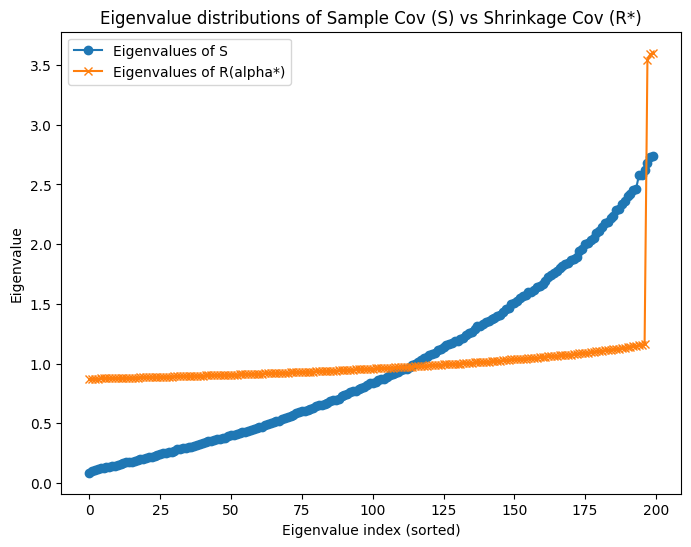

Frobenius norm squared of the difference from true covariance:
  ||S - I_p||^2_F = 99.803
  ||R(alpha*) - I_p||^2_F = 21.279


In [4]:
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# STEP 1: Define problem parameters and generate data
###############################################################################

# Set the random seed for reproducibility
np.random.seed(42)

# Dimensions:
p = 200  # dimension of each observation vector (number of "assets")
n = 400  # number of observations
q = 3    # number of factors we will extract in the factor model

# Generate data: X will be an (n x p) matrix of i.i.d. N(0,1),
# i.e. each row X[i,:] is one observation Xi in R^p
X = np.random.randn(n, p)

# We want to estimate the (unknown) covariance Sigma from these data.
# True Sigma = I_p in the problem statement, but we pretend we don't know it
# and proceed as if it's unknown.


###############################################################################
# STEP 2: Compute the sample covariance matrix S
###############################################################################

# By definition in the problem, the sample covariance (p x p) is
#   S = 1/n * X^T (I - (1/n) * 1 1^T) X
# which is basically "center X, then do (1/n) * (X^T X)".
# We can just use np.cov in Python, which returns the unbiased sample covariance.
# We'll do a "biased" version with factor 1/n instead of 1/(n-1), but either is fine.

# Center X by subtracting the mean from each column:
mean_est = X.mean(axis=0)   # shape (p,)
X_centered = X - mean_est

# Now compute S = (1/n) X_centered^T X_centered:
S = (X_centered.T @ X_centered) / n

# S is our (p x p) sample covariance estimate.


###############################################################################
# STEP 3: PCA to estimate the factor model: F = beta_hat beta_hat^T + sigma_hat^2 I
###############################################################################

# We'll do an eigen-decomposition of S, pick the top q eigenvalues & eigenvectors.
#  1) Sort the eigenvalues in descending order.
#  2) Let beta_hat = U_q * sqrt(Lambda_q), where U_q are top q eigenvectors,
#     Lambda_q are the top q eigenvalues (diagonal), so that beta_hat is p x q.
#  3) sigma_hat^2 = average of the remaining p - q eigenvalues.

# eigenvalue decomposition:
# eigvalsh returns eigenvalues in ascending order for symmetric/hermitian
w, v = np.linalg.eigh(S)  # w sorted ascending, v columns are evecs

# Reverse them so the largest are first
w = w[::-1]
v = v[:, ::-1]

# The top q eigenvalues and eigenvectors
lambda_top = w[:q]            # shape (q,)
V_top = v[:, :q]              # shape (p, q)

# The sum of the remaining p-q eigenvalues
lambda_tail = w[q:]           # shape (p-q,)

# Factor loadings: beta_hat = V_top * sqrt(diag(lambda_top)).
# We'll form a p x q matrix by scaling each column of V_top by sqrt(lambda_top[j]).
beta_hat = V_top @ np.diag(np.sqrt(lambda_top))   # shape (p, q)

# The estimate of sigma^2 is the average of the leftover eigenvalues:
if (p - q) > 0:
    sigma_hat_sq = np.mean(lambda_tail)
else:
    sigma_hat_sq = 0.0

# Now define F = beta_hat beta_hat^T + sigma_hat^2 I
F = beta_hat @ beta_hat.T + sigma_hat_sq * np.eye(p)


###############################################################################
# STEP 4: Define R(alpha) = alpha * F + (1-alpha) * S
###############################################################################

def R(alpha):
    """Return the shrinkage estimator R(alpha) = alpha*F + (1-alpha)*S."""
    return alpha * F + (1 - alpha) * S


###############################################################################
# STEP 5: Find alpha^* by naive grid search to minimize ||R(alpha)||^2_F
###############################################################################

# We'll define a function that returns the Frobenius norm squared of a matrix M:
def frob_sq(M):
    return np.linalg.norm(M, 'fro')**2

# We'll do a simple grid over alpha from 0 to 1 in steps of 0.01 (could be refined)
alpha_grid = np.linspace(0, 1, 1001)
frob_vals = []

for a in alpha_grid:
    Ra = R(a)
    frob_vals.append(frob_sq(Ra))

frob_vals = np.array(frob_vals)
idx_best = np.argmin(frob_vals)
alpha_star = alpha_grid[idx_best]

print(f"Best alpha in [0,1] by naive grid search = {alpha_star:.3f}")

# We'll define R_star = R(alpha_star)
R_star = R(alpha_star)


###############################################################################
# STEP 6: Plot the eigenvalue distribution of S and R(alpha^*)
###############################################################################

# Compute eigenvalues of S and R_star
eigvals_S = np.linalg.eigvalsh(S)      # ascending
eigvals_R = np.linalg.eigvalsh(R_star) # ascending

# Sort them so we can visualize
eigvals_S_sorted = np.sort(eigvals_S)
eigvals_R_sorted = np.sort(eigvals_R)

# Let's make a simple line plot showing how the eigenvalues are distributed
plt.figure(figsize=(8,6))
plt.plot(eigvals_S_sorted, label="Eigenvalues of S", marker='o')
plt.plot(eigvals_R_sorted, label="Eigenvalues of R(alpha*)", marker='x')
plt.title("Eigenvalue distributions of Sample Cov (S) vs Shrinkage Cov (R*)")
plt.xlabel("Eigenvalue index (sorted)")
plt.ylabel("Eigenvalue")
plt.legend()
plt.show()

# Compare sample covariance matrix S and shrinkage estimator R(alpha_star) by their distance from the true covariance matrix
print("Frobenius norm squared of the difference from true covariance:")
print(f"  ||S - I_p||^2_F = {frob_sq(S - np.eye(p)):.3f}")
print(f"  ||R(alpha*) - I_p||^2_F = {frob_sq(R_star - np.eye(p)):.3f}")

From the plot you can see that the sample covariance matrix $S$ has quite a broad spread in its eigenvalues—some go very near zero, while others are relatively large.  By contrast, the shrinkage estimator $R(\alpha^*)$ pulls or “shrinks” those extremes in toward a more moderate range.

In high‐dimensional settings (i.e., $p$ not small compared to $n$), the sample covariance matrix $S$ tends to be noisy:  
You often get a few artificially small eigenvalues, causing numerical instability or poor conditioning.  
Some eigenvalues become spuriously large, inflating variance estimates and distorting directions of largest variation.  

By blending $S$ with a more structured estimate $F$ (the factor model $\beta\beta^\top + \sigma^2I$), the shrinkage estimator $R(\alpha^*)$ ends up with a more stable eigenvalue spectrum.  This usually leads to lower estimation error and better out‐of‐sample performance, especially in portfolio or regression problems where a well‐conditioned covariance estimate is crucial.  Intuitively, you’re “smoothing out” the sample‐induced noise by forcing the eigenvalues to lie closer to a realistic range, rather than trusting the extremes of the sample covariance.